# Курсовой проект для курса "Python для Data Science"
Info Материалы к проекту (файлы): train.csv test.csv

Задание: Используя данные из train.csv, построить модель для предсказания цен на недвижимость (квартиры). С помощью полученной модели предсказать цены для квартир из файла test.csv.

Целевая переменная: Price

Основная метрика: R2 - коэффициент детерминации (sklearn.metrics.r2_score)


Сдача проекта:

Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту") ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook с расширением ipynb). Приложить файл с названием SZolotukhina_predictions.csv с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price). Сроки сдачи: Сдать проект за 72 часа.

Примечание: Все файлы csv должны содержать названия полей (header - то есть "шапку"), разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

## импортируем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from scipy.stats import norm
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

### импортируем данные для обучения модели и для тестирования

In [2]:
train = pd.read_csv('C:/Users/Светлана/Downloads/train.csv')
test = pd.read_csv('C:/Users/Светлана/Downloads/test.csv')
print("Data is loaded!")

Data is loaded!


In [3]:
print(f"Train:\t{train.shape[0]}\t sales and {train.shape[1]} features")
print(f'Test:\t{test.shape[0]}\t sales and {test.shape[1]} features')
train.shape[1]-1 == test.shape[1]

Train:	10000	 sales and 20 features
Test:	5000	 sales and 19 features


True

###### В тестовой на одну колонку меньше, т.к. на нем будем прогнозировать цену. Кол-во признаков в test и train совпадает (за минусом 1, т.к. обучающая выборка отличается от тестовой на одну колонку с целевой переменной)

### Посмотрим на данные и их тип

In [4]:
train.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [5]:
test.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

###### Обработка данных. Паралельно проведем и для Train и для Test. 
заменим тип данных, чтобы он не учитывался как цифровой признак, для колонок ID и DistrictId

In [8]:
train['Id'] = train['Id'].astype(str)
train['DistrictId'] = train['DistrictId'].astype(str)
test['Id'] = test['Id'].astype(str)
test['DistrictId'] = test['DistrictId'].astype(str)

In [9]:
# кол-во комнат с плавающей точкой, не совсем корректно и логично, зампеним тип данных, как и этажи
train['Rooms'] = train['Rooms'].astype('int64')
test['Rooms'] = test['Rooms'].astype('int64')
train['HouseFloor'] = train['HouseFloor'].astype('int64')
test['HouseFloor'] = test['HouseFloor'].astype('int64')

In [10]:
train.dtypes

Id                object
DistrictId        object
Rooms              int64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor         int64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [11]:
test.dtypes

Id                object
DistrictId        object
Rooms              int64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor         int64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

#### с типами данных ок

###### Видим что у нас есть пропуски по двум признакам, есть категориальные переменные


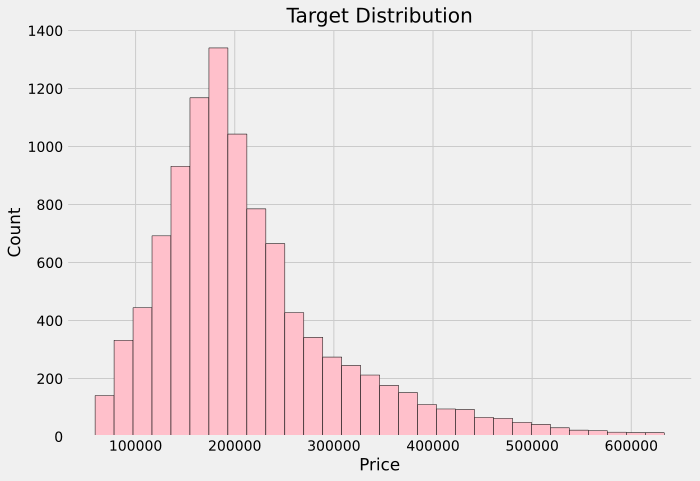

In [12]:
plt.figure(figsize = (10, 7))
train['Price'].hist(bins=30, ec='black', color='pink')
plt.xlabel('Price')
plt.ylabel('Count')
plt.title('Target Distribution')
plt.show()

#### наблюдаем "хвост" с анамально высокими ценами. Максимум распределения в районе 180 000

In [13]:
train.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [14]:
test.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


##### ID и DistrictId в стат.характеристики не вошли, т.к. мы их привели к типу строка. Анализируем стат.данные - у нас есть значения 0 в минимальном кол-ве комнат, в площажи кухни и в общем кол-ве этажей в доме. Можно допустить что число комнат = 0 в студиях, как и площадь кухни (если это общее пространство), а вот в этажностью дома, вероятно это либо ошибка, либо не было данных по этажности дома.

In [15]:
# Проверим предположения по 0
train[train['Rooms'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1397,12638,27,0,138.427694,136.215499,0.0,4,3,2016,0.075424,B,B,11,3097,0,NaN,0,0,B,268394.744389
1981,7917,27,0,212.932361,211.231125,0.0,2,3,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.260887
2269,7317,27,0,41.790881,NaN,0.0,13,0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,98129.976788
3911,770,28,0,49.483501,NaN,0.0,16,0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.338463
4366,456,6,0,81.491446,NaN,0.0,4,0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.799112
4853,3224,27,0,2.377248,0.873147,0.0,1,0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.941798
6149,3159,88,0,38.697117,19.345131,9.0,9,16,1982,0.127376,B,B,43,8429,3,NaN,3,9,B,158998.110646
8834,9443,27,0,87.762616,85.125471,0.0,5,15,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,219281.918007


In [16]:
test[test['Rooms'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
2406,3343,58,0,116.824201,113.692424,0.0,3,3,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B
2524,10729,27,0,76.345154,42.820796,12.0,14,0,1977,0.017647,B,B,2,469,0,NaN,0,0,B


##### видим что для числа комнат = 0 есть как вполне адекватные площади 38-81, так и завышенные 116(test)-212(train) и заниженные 2, и в них площадь кухни = 0 (за исключением одной квартиры). Всего таких объектов 8 (на фоне 10000 выборки это незначительный процент, даже если это ошибка), но заменим их на медианное значение

In [17]:
# так же есть квартиры с кол-вом комнат больше 6 (10, 19)
train[train['Rooms'] > 6]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
377,5927,57,10,59.056975,36.223072,10.0,22,22,2002,0.090799,B,B,74,19083,2,NaN,5,15,B,317265.323792
1454,8491,1,19,42.006046,21.779288,7.0,17,17,2014,0.007122,B,B,1,264,0,NaN,0,1,B,78364.616704
8849,14865,9,10,60.871266,38.420681,10.0,3,2,1994,0.161532,B,B,25,5648,1,30.0,2,4,B,172329.270863


In [18]:
test[test['Rooms'] > 6]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
3398,1435,111,17,52.866107,32.528342,8.0,15,17,1987,0.093443,B,B,23,4635,5,3300.0,2,4,B


#### Кол-во комнат 10, 19 - а вот площадь не соответствует такому кол-ву комнат. Заменим на медиану (т.к. медиана более устойчива к выбросам и намалиям, чем среднее значение). В тестовой выборке попало значение с 17 комнатами, при этом площадь 52,9

In [19]:
median_rooms = train['Rooms'].median()
median_rooms_test = test['Rooms'].median()

In [20]:
median_rooms

2.0

In [21]:
median_rooms_test

2.0

In [22]:
train.loc[train['Rooms'] > 6, 'Rooms'] = median_rooms

In [23]:
test.loc[test['Rooms'] > 6, 'Rooms'] = median_rooms_test

In [24]:
train.loc[train['Rooms'] == 0, 'Rooms'] = median_rooms

In [25]:
test.loc[test['Rooms'] == 0, 'Rooms'] = median_rooms_test

In [26]:
train[train['Rooms'] > 6]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


In [27]:
test[test['Rooms'] > 6]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2


In [28]:
# Проверим предположения по 0, и поработаем с ним
train[train['HouseFloor'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
7,11993,74,2,80.312926,NaN,0.0,14,0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,221244.156664
23,6641,54,3,118.907612,NaN,0.0,2,0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,571069.052600
26,4378,27,3,106.958871,0.641822,0.0,17,0,2018,0.072158,B,B,2,629,1,NaN,0,0,A,337299.867936
39,9371,23,2,60.503248,NaN,0.0,16,0,1977,0.034656,B,B,0,168,0,NaN,0,0,B,229778.057902
44,10521,38,3,104.211396,106.340403,0.0,20,0,2017,0.060753,B,B,15,2787,2,520.0,0,7,B,435462.048070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9707,12302,30,1,46.072913,48.307844,0.0,4,0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B,161403.094034
9769,9384,59,3,98.607328,NaN,0.0,14,0,1977,0.019509,B,B,37,7687,11,176.0,5,5,B,492700.257473
9878,11441,62,2,71.985335,72.453232,0.0,5,0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,158841.624543
9908,3171,62,1,35.873961,NaN,0.0,25,0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,134379.130962


In [29]:
test[test['HouseFloor'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
22,12694,27,3,83.670032,46.358356,0.0,8,0,2015,0.072158,B,B,2,629,1,NaN,0,0,A
24,8968,27,2,69.849239,NaN,0.0,3,0,1977,0.011654,B,B,4,915,0,NaN,0,0,B
30,2982,6,2,63.460684,NaN,0.0,13,0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B
32,2449,1,1,66.426585,NaN,0.0,14,0,1977,0.007122,B,B,1,264,0,NaN,0,1,B
46,12309,45,1,42.899569,NaN,0.0,25,0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4856,10262,27,2,69.196440,NaN,0.0,10,0,1977,0.017647,B,B,2,469,0,NaN,0,0,B
4887,12116,88,3,89.549559,NaN,0.0,20,0,1977,0.127376,B,B,43,8429,3,NaN,3,9,B
4892,16357,58,1,49.205978,NaN,0.0,4,0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B
4976,4723,95,1,45.542940,NaN,0.0,6,0,1977,0.000699,B,B,14,3369,24,4129.0,0,3,B


In [30]:
len(train[train['HouseFloor'] == 0])

269

In [31]:
len(test[test['HouseFloor'] == 0])

131

In [32]:
median_housefloor = train['HouseFloor'].median()
median_housefloor

13.0

In [33]:
median_housefloor_test = test['HouseFloor'].median()
median_housefloor_test

12.0

In [34]:
train.loc[train['HouseFloor'] == 0, 'HouseFloor'] = median_housefloor

In [35]:
test.loc[test['HouseFloor'] == 0, 'HouseFloor'] = median_housefloor_test

In [36]:
train[train['HouseFloor'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


In [37]:
test[test['HouseFloor'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2


In [38]:
#поработаем с этажностью, логично, что не может квартира находитья на этаже большем, чем общее кол-во экажей к здании
train[train['Floor'] > train['HouseFloor']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
7,11993,74,2,80.312926,NaN,0.0,14,13,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,221244.156664
14,10953,27,1,53.769097,52.408027,1.0,5,4,1977,0.072158,B,B,2,629,1,NaN,0,0,A,140647.565937
16,2119,27,2,49.360648,31.993964,5.0,6,5,1983,0.051815,B,B,5,1227,0,NaN,0,0,B,117000.381287
21,11935,27,2,64.711835,NaN,1.0,15,1,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,127200.026511
26,4378,27,3,106.958871,0.641822,0.0,17,13,2018,0.072158,B,B,2,629,1,NaN,0,0,A,337299.867936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9984,2237,52,3,64.074977,47.633428,6.0,11,9,1983,0.371149,B,B,34,7065,1,750.0,2,5,B,226434.880156
9985,16159,27,1,38.968338,NaN,1.0,10,1,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,95529.569405
9989,4145,96,3,90.055233,47.860231,11.0,26,24,2005,0.041116,B,B,53,14892,4,NaN,1,4,B,441108.911237
9991,11553,3,3,101.622794,51.628780,12.0,18,17,2000,0.265089,B,B,37,5288,0,1937.0,3,2,B,212883.501504


In [39]:
test[test['Floor'] > test['HouseFloor']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
1,15856,74,2,69.263183,NaN,1.0,6,1,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
10,15975,61,3,64.543658,42.651541,7.0,10,9,1981,0.300323,B,B,52,10311,6,NaN,1,9,B
14,5214,27,1,37.555197,NaN,1.0,5,1,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
27,11160,58,1,48.610661,48.752502,1.0,4,3,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B
30,2982,6,2,63.460684,NaN,0.0,13,12,1977,0.243205,B,B,5,1564,0,540.0,0,0,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4968,15181,27,4,104.664209,66.903563,1.0,4,1,2016,0.017647,B,B,2,469,0,NaN,0,0,B
4972,16064,30,1,38.376234,37.003311,1.0,2,1,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B
4989,2591,39,2,44.203592,30.191691,6.0,10,9,1972,0.428826,B,B,25,5011,8,730.0,0,2,B
4993,14562,113,2,46.627882,27.058739,5.0,6,5,1969,0.307467,B,A,30,5048,9,325.0,2,5,B


In [40]:
# там где квартира расположена на этаже большем чем кол-во этажей, заменим значение на максимальный этаж в здании
# может при опросе хозяин забыл сколько этажей, но знает что у него последний
train.loc[train['Floor'] > train['HouseFloor'],
           'Floor'] = train.loc[train['Floor'] > train['HouseFloor'], 'HouseFloor']

In [41]:
test.loc[test['Floor'] > test['HouseFloor'],
           'Floor'] = test.loc[test['Floor'] > test['HouseFloor'], 'HouseFloor']

In [42]:
train[train['Floor'] > train['HouseFloor']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


In [43]:
test[test['Floor'] > test['HouseFloor']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2


In [44]:
# посмотрим по площади квартир более 200
train[train['Square'] > 200]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1981,7917,27,2,212.932361,211.231125,0.0,2,3,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.260887
1982,5548,86,5,275.645284,233.949309,26.0,12,37,2011,0.161976,B,A,31,7010,5,4508.0,3,7,B,455264.882666
4262,28,9,2,604.705972,NaN,1.0,17,18,1977,0.161532,B,B,25,5648,1,30.0,2,4,B,187717.242538
4690,2307,102,1,409.425181,410.639749,10.0,4,4,2016,0.238617,B,B,26,3889,6,705.0,3,6,B,90470.430830
6977,11602,30,2,641.065193,638.163193,10.0,19,19,2019,0.000078,B,B,22,6398,141,1046.0,3,23,B,133529.681562
9910,16568,27,4,200.334539,201.627361,25.0,1,2,2013,0.041116,B,B,53,14892,4,NaN,1,4,B,528560.506016


In [45]:
test[test['Square'] > 200]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
3217,4058,27,6,223.453689,104.113552,16.0,2,2,2017,0.041116,B,B,53,14892,4,NaN,1,4,B
3909,1397,76,3,221.138768,118.055342,4.0,32,48,2011,0.000000,B,B,7,1660,39,1786.0,1,5,B


In [46]:
len(train[train['Square'] > 200])

6

#### вероятнее всего опечатка в площади квартир более 400 кв.м., т.к. стоимость на такие квартиры не превышает среднюю стоимость по выборке

In [47]:
train.loc[train['Square'] > 400, 'Square'] = train.loc[train['Square'] > 400, 'Square'] / 10

In [48]:
test.loc[test['Square'] > 400, 'Square'] = test.loc[test['Square'] > 400, 'Square'] / 10

In [49]:
train[train['Square'] > 200]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1981,7917,27,2,212.932361,211.231125,0.0,2,3,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.260887
1982,5548,86,5,275.645284,233.949309,26.0,12,37,2011,0.161976,B,A,31,7010,5,4508.0,3,7,B,455264.882666
9910,16568,27,4,200.334539,201.627361,25.0,1,2,2013,0.041116,B,B,53,14892,4,NaN,1,4,B,528560.506016


In [50]:
test[test['Square'] > 200]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
3217,4058,27,6,223.453689,104.113552,16.0,2,2,2017,0.041116,B,B,53,14892,4,NaN,1,4,B
3909,1397,76,3,221.138768,118.055342,4.0,32,48,2011,0.000000,B,B,7,1660,39,1786.0,1,5,B


#### поработаем с той площадью квартиры, где она меньше жилой площади и поработаем с ней

In [51]:
train.loc[train['Square'] < train['LifeSquare'],
           'Square'] = train.loc[train['Square'] < train['LifeSquare'], 'LifeSquare']

In [52]:
train[train['Square'] < train['LifeSquare']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


In [53]:
test.loc[test['Square'] < test['LifeSquare'],
           'Square'] = test.loc[test['Square'] < test['LifeSquare'], 'LifeSquare']

In [54]:
test[test['Square'] < test['LifeSquare']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2


In [55]:
#Fix HouseYear
train[train['HouseYear'] > 2020]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1497,10814,109,1,37.265070,20.239714,9.0,9,12,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B,254084.534396
4189,11607,147,2,44.791836,28.360393,5.0,4,9,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B,243028.603096


In [56]:
test[test['HouseYear'] > 2020]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2


##### с годом постройки 20052011 - вероятнее всего от интервал, огде нет точных данных  и построен дом в период с 2005 по 2011 год, а 4968 - опечатка и вместо 4 нужно1 = 1968

In [57]:
train.loc[train['HouseYear'] == 20052011, 'HouseYear'] = int((2005 + 2011) / 2)
train.loc[train['HouseYear'] == 4968, 'HouseYear'] = 1968

In [58]:
train[train['HouseYear'] > 2020]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


In [59]:
#Поработаем с KitchenSquare, площадь менее 3, нелогичная
train[train['KitchenSquare'] < 3]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2,4765,53,2,44.947953,29.197612,0.0,8,12,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
7,11993,74,2,80.312926,NaN,0.0,13,13,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,221244.156664
8,5172,1,2,64.511437,NaN,1.0,9,17,1977,0.007122,B,B,1,264,0,NaN,0,1,B,229102.795999
12,6452,13,2,54.522805,31.759753,1.0,8,12,1999,0.090799,B,B,74,19083,2,NaN,5,15,B,229220.372609
14,10953,27,1,53.769097,52.408027,1.0,4,4,1977,0.072158,B,B,2,629,1,NaN,0,0,A,140647.565937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,16159,27,1,38.968338,NaN,1.0,1,1,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,95529.569405
9986,2996,1,2,64.994245,NaN,1.0,9,22,1977,0.007122,B,B,1,264,0,NaN,0,1,B,200332.511658
9987,15623,23,2,55.620092,NaN,0.0,2,4,1977,0.034656,B,B,0,168,0,NaN,0,0,B,115797.553006
9994,4158,23,2,64.864198,NaN,1.0,17,17,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,171323.515653


In [60]:
test[test['KitchenSquare'] < 3]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
1,15856,74,2,69.263183,NaN,1.0,1,1,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
4,14275,27,1,47.527111,43.387569,1.0,17,17,2017,0.072158,B,B,2,629,1,NaN,0,0,A
5,7633,53,1,40.675627,NaN,1.0,21,21,1977,0.049637,B,B,34,7759,0,229.0,1,3,B
6,13329,23,2,68.099538,64.843025,1.0,2,17,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
11,3310,6,3,84.625350,NaN,1.0,6,17,1977,0.243205,B,B,5,1564,0,540.0,0,0,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4982,12920,23,1,39.610426,38.187571,1.0,6,18,2013,0.034656,B,B,0,168,0,NaN,0,0,B
4985,11732,1,1,46.597283,NaN,1.0,17,24,1977,0.007122,B,B,1,264,0,NaN,0,1,B
4987,5361,53,3,80.102103,NaN,1.0,13,22,1977,0.049637,B,B,34,7759,0,229.0,1,3,B
4998,4780,62,2,81.305222,NaN,0.0,4,12,1977,0.072158,B,B,2,629,1,NaN,0,0,A


In [61]:
train.loc[train['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [62]:
test.loc[test['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [63]:
train[train['KitchenSquare'] < 3]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


In [64]:
test[test['KitchenSquare'] < 3]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2


### Номинативные переменные

In [65]:
train.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [66]:
test.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [67]:
train['DistrictId'].value_counts().head()

27    851
1     652
23    565
6     511
9     294
Name: DistrictId, dtype: int64

In [68]:
test['DistrictId'].value_counts().head()

27    391
1     344
23    264
6     257
9     132
Name: DistrictId, dtype: int64

#### преобладают районы 27, 1, 23, 6. в районе 9 значительно меньше квартир

In [69]:
train['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [70]:
train['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [71]:
train['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

In [72]:
test['Ecology_2'].value_counts()

B    4952
A      48
Name: Ecology_2, dtype: int64

In [73]:
test['Ecology_3'].value_counts()

B    4851
A     149
Name: Ecology_3, dtype: int64

In [74]:
test['Shops_2'].value_counts()

B    4588
A     412
Name: Shops_2, dtype: int64

#### по параметрам экологии и инфроструктуры - преобладает явно один параметр В в каждой категории

## Обработка выбросов

In [75]:
train['Rooms'].value_counts()

2    3891
1    3705
3    2235
4     150
5      18
6       1
Name: Rooms, dtype: int64

In [76]:
test['Rooms'].value_counts()

2    2033
1    1769
3    1099
4      90
5       7
6       2
Name: Rooms, dtype: int64

#### явно преобладают одно и двухкомнатные квартиры, квартиры с 0, 10, 19 комнатами мы ранее заменили на медианное значение

In [77]:
# Отсечем выбросы
train = train[train['Square'].isnull() | 
    (train['Square'] < train['Square'].quantile(.975)) | 
    (train['Square'] > train['Square'].quantile(.025))]
train = train[train['LifeSquare'].isnull() | 
    (train['LifeSquare'] < train['LifeSquare'].quantile(.975)) | 
    (train['LifeSquare'] > train['LifeSquare'].quantile(.025))]
train = train[train['KitchenSquare'].isnull() | 
    (train['KitchenSquare'] < train['KitchenSquare'].quantile(.975))]


In [78]:
test = test[test['Square'].isnull() | 
    (test['Square'] < test['Square'].quantile(.975)) | 
    (test['Square'] > test['Square'].quantile(.025))]
test = test[test['LifeSquare'].isnull() | 
    (test['LifeSquare'] < test['LifeSquare'].quantile(.975)) | 
    (test['LifeSquare'] > test['LifeSquare'].quantile(.025))]
test = test[test['KitchenSquare'].isnull() | 
    (test['KitchenSquare'] < test['KitchenSquare'].quantile(.975))]

In [79]:
train.shape

(9744, 20)

In [80]:
test.shape

(4754, 19)

In [81]:
# поработаем с пропусками
len(train) - train.count()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2102
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4673
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [82]:
len(test) - test.count()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1028
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2267
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

#### с нулями все неплохо, только в двух колонках.

In [83]:
#По площадям квартиры
train[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

,Square,LifeSquare,KitchenSquare
0,47.981561,29.442751,6.0
1,65.683640,40.049543,8.0
2,44.947953,29.197612,3.0
3,53.352981,52.731512,9.0
4,39.649192,23.776169,7.0
5,80.384479,46.683720,12.0
6,62.254114,37.160377,7.0
7,80.312926,NaN,3.0
8,64.511437,NaN,3.0
9,46.461409,18.915552,8.0


In [84]:
test[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

,Square,LifeSquare,KitchenSquare
0,49.882643,33.432782,6.0
1,69.263183,NaN,3.0
3,73.046609,51.940842,9.0
4,47.527111,43.387569,3.0
5,40.675627,NaN,3.0
6,68.099538,64.843025,3.0
7,48.193897,32.857644,6.0
8,72.277106,45.968758,9.0
9,80.219400,47.660260,9.0
10,64.543658,42.651541,7.0


In [85]:
train.loc[train['LifeSquare'].isnull(), 'LifeSquare'] = train['LifeSquare'].median()

In [86]:
test.loc[test['LifeSquare'].isnull(), 'LifeSquare'] = test['LifeSquare'].median()

In [87]:
#поработаем с нулями в Healthcare_1
train.loc[train['Healthcare_1'].isnull(), 'Healthcare_1'] = train['Healthcare_1'].median()

In [88]:
test.loc[test['Healthcare_1'].isnull(), 'Healthcare_1'] = test['Healthcare_1'].median()

In [89]:
len(train) - train.count()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
dtype: int64

In [90]:
len(test) - test.count()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
dtype: int64

### поработаем с Dummies

In [91]:
train['Ecology_2_bin'] = train['Ecology_2'].replace({'A':0, 'B':1})
train['Ecology_3_bin'] = train['Ecology_3'].replace({'A':0, 'B':1})
train['Shops_2_bin'] = train['Shops_2'].replace({'A':0, 'B':1})

In [92]:
test['Ecology_2_bin'] = test['Ecology_2'].replace({'A':0, 'B':1})
test['Ecology_3_bin'] = test['Ecology_3'].replace({'A':0, 'B':1})
test['Shops_2_bin'] = test['Shops_2'].replace({'A':0, 'B':1})

In [93]:
district_size = train['DistrictId'].value_counts().reset_index()\
    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
district_size.head()

,DistrictId,DistrictSize
0,27,810
1,1,646
2,23,546
3,6,503
4,9,292


In [94]:
district_size = test['DistrictId'].value_counts().reset_index()\
    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
district_size.head()

,DistrictId,DistrictSize
0,27,358
1,1,339
2,23,255
3,6,229
4,9,127


In [95]:
#объединим полученную табличку c номерами района с обучающей выборкой
train = train.merge(district_size, on='DistrictId', how='left')
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
0,14038,35,2,47.981561,29.442751,6.0,7,9,1969,0.089040,...,5,900.0,0,11,B,184966.930730,1,1,1,14.0
1,15053,41,3,65.683640,40.049543,8.0,7,9,1978,0.000070,...,1,240.0,1,16,B,300009.450063,1,1,1,42.0
2,4765,53,2,44.947953,29.197612,3.0,8,12,1968,0.049637,...,0,229.0,1,3,B,220925.908524,1,1,1,88.0
3,5809,58,2,53.352981,52.731512,9.0,8,17,1977,0.437885,...,3,1084.0,0,5,B,175616.227217,1,1,1,85.0
4,10783,99,1,39.649192,23.776169,7.0,11,12,1976,0.012339,...,1,2078.0,2,4,B,150226.531644,1,1,1,41.0


In [96]:
test = test.merge(district_size, on='DistrictId', how='left')
test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
0,725,58,2,49.882643,33.432782,6.0,6,14,1972,0.310199,...,2748,1,900.0,0,0,B,1,1,1,85
1,15856,74,2,69.263183,32.361725,3.0,1,1,1977,0.075779,...,1437,3,900.0,0,2,B,1,1,1,54
2,15664,47,2,73.046609,51.940842,9.0,22,22,2007,0.101872,...,4583,3,900.0,3,3,B,1,1,1,49
3,14275,27,1,47.527111,43.387569,3.0,17,17,2017,0.072158,...,629,1,900.0,0,0,A,1,1,0,358
4,7633,53,1,40.675627,32.361725,3.0,21,21,1977,0.049637,...,7759,0,229.0,1,3,B,1,1,1,88


In [97]:
(train['DistrictSize'] > 100).value_counts()

False    6491
True     3253
Name: DistrictSize, dtype: int64

In [98]:
(test['DistrictSize'] > 100).value_counts()

False    3220
True     1534
Name: DistrictSize, dtype: int64

In [99]:
#создадим новую категорию (относится к большим районам или нет)
train['IsDistrictLarge'] = (train['DistrictSize'] > 100).astype(int)

In [100]:
test['IsDistrictLarge'] = (test['DistrictSize'] > 100).astype(int)

In [101]:
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge
0,14038,35,2,47.981561,29.442751,6.0,7,9,1969,0.089040,...,900.0,0,11,B,184966.930730,1,1,1,14.0,0
1,15053,41,3,65.683640,40.049543,8.0,7,9,1978,0.000070,...,240.0,1,16,B,300009.450063,1,1,1,42.0,0
2,4765,53,2,44.947953,29.197612,3.0,8,12,1968,0.049637,...,229.0,1,3,B,220925.908524,1,1,1,88.0,0
3,5809,58,2,53.352981,52.731512,9.0,8,17,1977,0.437885,...,1084.0,0,5,B,175616.227217,1,1,1,85.0,0
4,10783,99,1,39.649192,23.776169,7.0,11,12,1976,0.012339,...,2078.0,2,4,B,150226.531644,1,1,1,41.0,0


In [102]:
test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge
0,725,58,2,49.882643,33.432782,6.0,6,14,1972,0.310199,...,1,900.0,0,0,B,1,1,1,85,0
1,15856,74,2,69.263183,32.361725,3.0,1,1,1977,0.075779,...,3,900.0,0,2,B,1,1,1,54,0
2,15664,47,2,73.046609,51.940842,9.0,22,22,2007,0.101872,...,3,900.0,3,3,B,1,1,1,49,0
3,14275,27,1,47.527111,43.387569,3.0,17,17,2017,0.072158,...,1,900.0,0,0,A,1,1,0,358,1
4,7633,53,1,40.675627,32.361725,3.0,21,21,1977,0.049637,...,0,229.0,1,3,B,1,1,1,88,0


In [103]:
# Группировка по номеру района и кол-ву комнат
med_price_by_dustrict = train.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price': 'median'})\
    .rename(columns={'Price':"MedPriceByDistrict"})
med_price_by_dustrict.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1,142486.170594
1,0,2,176210.812334
2,0,3,308098.189977
3,1,1,147110.201250
4,1,2,202626.530012


### получили медианную стоимость квартир для определенного района с определенным кол-вом комнат

In [104]:
#объединим полученную табличку  с обучающей выборкой
train = train.merge(med_price_by_dustrict, on=['DistrictId', 'Rooms'], how='left')
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,14038,35,2,47.981561,29.442751,6.0,7,9,1969,0.089040,...,0,11,B,184966.930730,1,1,1,14.0,0,207786.135836
1,15053,41,3,65.683640,40.049543,8.0,7,9,1978,0.000070,...,1,16,B,300009.450063,1,1,1,42.0,0,297041.145784
2,4765,53,2,44.947953,29.197612,3.0,8,12,1968,0.049637,...,1,3,B,220925.908524,1,1,1,88.0,0,261705.465881
3,5809,58,2,53.352981,52.731512,9.0,8,17,1977,0.437885,...,0,5,B,175616.227217,1,1,1,85.0,0,166809.665642
4,10783,99,1,39.649192,23.776169,7.0,11,12,1976,0.012339,...,2,4,B,150226.531644,1,1,1,41.0,0,158539.052715


In [105]:
test = test.merge(med_price_by_dustrict, on=['DistrictId', 'Rooms'], how='left')
test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,725,58,2,49.882643,33.432782,6.0,6,14,1972,0.310199,...,900.0,0,0,B,1,1,1,85,0,166809.665642
1,15856,74,2,69.263183,32.361725,3.0,1,1,1977,0.075779,...,900.0,0,2,B,1,1,1,54,0,242515.793425
2,15664,47,2,73.046609,51.940842,9.0,22,22,2007,0.101872,...,900.0,3,3,B,1,1,1,49,0,222227.584211
3,14275,27,1,47.527111,43.387569,3.0,17,17,2017,0.072158,...,900.0,0,0,A,1,1,0,358,1,117711.346469
4,7633,53,1,40.675627,32.361725,3.0,21,21,1977,0.049637,...,229.0,1,3,B,1,1,1,88,0,195474.299127


In [106]:
#медианная цена по площади:
med_price_by_square = train.groupby(['Square'], as_index=False).agg({'Price': 'median'})\
    .rename(columns={'Price':"MedPriceBySquare"})
med_price_by_square.head()

,Square,MedPriceBySquare
0,2.377248,126596.941798
1,2.642219,458378.777006
2,4.525736,181434.825589
3,4.604943,137597.601458
4,4.618547,483283.488083


In [107]:
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,14038,35,2,47.981561,29.442751,6.0,7,9,1969,0.089040,...,0,11,B,184966.930730,1,1,1,14.0,0,207786.135836
1,15053,41,3,65.683640,40.049543,8.0,7,9,1978,0.000070,...,1,16,B,300009.450063,1,1,1,42.0,0,297041.145784
2,4765,53,2,44.947953,29.197612,3.0,8,12,1968,0.049637,...,1,3,B,220925.908524,1,1,1,88.0,0,261705.465881
3,5809,58,2,53.352981,52.731512,9.0,8,17,1977,0.437885,...,0,5,B,175616.227217,1,1,1,85.0,0,166809.665642
4,10783,99,1,39.649192,23.776169,7.0,11,12,1976,0.012339,...,2,4,B,150226.531644,1,1,1,41.0,0,158539.052715


In [108]:
#добавим в выборку данные медианной цены
train.merge(med_price_by_square, on='Square', how='left').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9744 entries, 0 to 9743
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  9744 non-null   object 
 1   DistrictId          9744 non-null   object 
 2   Rooms               9744 non-null   int64  
 3   Square              9744 non-null   float64
 4   LifeSquare          9744 non-null   float64
 5   KitchenSquare       9744 non-null   float64
 6   Floor               9744 non-null   int64  
 7   HouseFloor          9744 non-null   int64  
 8   HouseYear           9744 non-null   int64  
 9   Ecology_1           9744 non-null   float64
 10  Ecology_2           9744 non-null   object 
 11  Ecology_3           9744 non-null   object 
 12  Social_1            9744 non-null   int64  
 13  Social_2            9744 non-null   int64  
 14  Social_3            9744 non-null   int64  
 15  Healthcare_1        9744 non-null   float64
 16  Helthc

## Приступаем к отбору признаков

In [109]:
train.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'Shops_2_bin',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict']

In [110]:
# сохраним по спискам
# изночальные признаки
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1',  'Shops_2_bin', 'DistrictSize']
#новые признаки
new_feature_names = ['IsDistrictLarge', 'MedPriceByDistrict']
# Таргетируемый признак
target_name = ['Price']


### построим несколько моделей и оценим качество на отложенной выборке по метрике R^2
### из построенных модель выберем baseline модель с наилучшим качеством

In [111]:
print(train.isna().sum().sum())

30


In [112]:
train = train.fillna(train.mean())

In [113]:
print(train.isna().sum().sum())

0


In [114]:
X = train[feature_names + new_feature_names]

y = train[target_name]

In [115]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

In [116]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6820 entries, 530 to 7270
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Rooms               6820 non-null   int64  
 1   Square              6820 non-null   float64
 2   LifeSquare          6820 non-null   float64
 3   KitchenSquare       6820 non-null   float64
 4   Floor               6820 non-null   int64  
 5   HouseFloor          6820 non-null   int64  
 6   HouseYear           6820 non-null   int64  
 7   Ecology_1           6820 non-null   float64
 8   Ecology_2_bin       6820 non-null   int64  
 9   Ecology_3_bin       6820 non-null   int64  
 10  Social_1            6820 non-null   int64  
 11  Social_2            6820 non-null   int64  
 12  Social_3            6820 non-null   int64  
 13  Healthcare_1        6820 non-null   float64
 14  Helthcare_2         6820 non-null   int64  
 15  Shops_1             6820 non-null   int64  
 16  Shop

In [117]:
X_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2924 entries, 6216 to 2905
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Rooms               2924 non-null   int64  
 1   Square              2924 non-null   float64
 2   LifeSquare          2924 non-null   float64
 3   KitchenSquare       2924 non-null   float64
 4   Floor               2924 non-null   int64  
 5   HouseFloor          2924 non-null   int64  
 6   HouseYear           2924 non-null   int64  
 7   Ecology_1           2924 non-null   float64
 8   Ecology_2_bin       2924 non-null   int64  
 9   Ecology_3_bin       2924 non-null   int64  
 10  Social_1            2924 non-null   int64  
 11  Social_2            2924 non-null   int64  
 12  Social_3            2924 non-null   int64  
 13  Healthcare_1        2924 non-null   float64
 14  Helthcare_2         2924 non-null   int64  
 15  Shops_1             2924 non-null   int64  
 16  Sho

In [118]:
X_train.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2_bin,Ecology_3_bin,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2_bin,DistrictSize,IsDistrictLarge,MedPriceByDistrict
530,2,54.264373,33.633644,8.0,5,12,1983,0.049637,1,1,34,7759,0,229.0,1,3,1,88.0,0,261705.465881
4056,1,29.833612,32.525279,3.0,2,17,2015,0.000078,1,1,22,6398,141,1046.0,3,23,1,114.0,1,128649.191084
996,1,34.323227,19.369105,5.0,5,5,1965,0.086885,1,1,10,2277,2,1547.0,0,0,1,55.0,0,152851.632587
8400,1,39.714583,32.525279,3.0,5,17,1977,0.000078,1,1,22,6398,141,1046.0,3,23,1,114.0,1,128649.191084
2312,2,56.818449,34.371711,9.0,4,10,1997,0.090799,1,1,74,19083,2,900.0,5,15,1,46.0,0,241068.903045


In [119]:
y_train.head()

,Price
530,264602.817769
4056,68185.043135
996,140995.398666
8400,134087.397831
2312,246103.408671


In [120]:
#начнем работу по выбору модели

In [121]:
scaler = StandardScaler()

In [122]:
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

In [123]:
##### Можно и через 
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

In [124]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6820 entries, 530 to 7270
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Rooms               6820 non-null   int64  
 1   Square              6820 non-null   float64
 2   LifeSquare          6820 non-null   float64
 3   KitchenSquare       6820 non-null   float64
 4   Floor               6820 non-null   int64  
 5   HouseFloor          6820 non-null   int64  
 6   HouseYear           6820 non-null   int64  
 7   Ecology_1           6820 non-null   float64
 8   Ecology_2_bin       6820 non-null   int64  
 9   Ecology_3_bin       6820 non-null   int64  
 10  Social_1            6820 non-null   int64  
 11  Social_2            6820 non-null   int64  
 12  Social_3            6820 non-null   int64  
 13  Healthcare_1        6820 non-null   float64
 14  Helthcare_2         6820 non-null   int64  
 15  Shops_1             6820 non-null   int64  
 16  Shop

#### Проверим какая модель покажет лучший результат r2

In [125]:
model_dict = {
   'lr': LinearRegression(),
#    'lasso': Lasso(random_state=42),
#    'ridge': Ridge(random_state=42),
#    'enet': ElasticNet(random_state=42),
   'knn': KNeighborsRegressor(),
   'dt': DecisionTreeRegressor(random_state=42),
   'rf': RandomForestRegressor(random_state=42)
}

score_list = []

for model in model_dict:
    model_dict[model].fit(X_train_scaled, y_train)
    y_pred_train = model_dict[model].predict(X_train_scaled)
    y_pred_valid = model_dict[model].predict(X_valid_scaled)
    score_train = r2_score(y_train, y_pred_train)
    score_valid = r2_score(y_valid, y_pred_valid)
    score_list.append((score_train, score_valid))

for model, scores in zip(model_dict.keys(), score_list):
    print(f'{model}: \n\ttrain: {np.round(scores[0], 4)} \n\tvalid: {np.round(scores[1], 4)}')

lr: 
	train: 0.67 
	valid: 0.6738
knn: 
	train: 0.7792 
	valid: 0.6724
dt: 
	train: 1.0 
	valid: 0.5425
rf: 
	train: 0.9643 
	valid: 0.7598


In [126]:
# с минимальной предобработкой данных лучший результат показала модель RandomForest
# R^2 = train: 0.9644 и valid: 0.7591
# продолжим работать с моделью RandomForest

In [127]:
# проведем настройку гиперпараметров модели с помощью RandomizedSearchCV

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

random_grid = {
    'n_estimators': np.arange(200, 501, 20),
    'max_depth': np.arange(2, 51, 2),
    'max_features': np.arange (5, 20),
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=random_grid,
    n_iter=50,
    scoring='r2',
    cv=10,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_scaled, y_train)

print(random_search.best_score_)
print(random_search.best_params_)

Fitting 10 folds for each of 50 candidates, totalling 500 fits
0.7555218110716442
{'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 12, 'max_depth': 18}


In [128]:
# измерим качество подобранной модели на отложенной выборке

y_pred_train = random_search.best_estimator_.predict(X_train_scaled)
y_pred_valid = random_search.best_estimator_.predict(X_valid_scaled)

score_train = r2_score(y_train, y_pred_train)
score_valid = r2_score(y_valid, y_pred_valid)

print(f'train: {np.round(score_train, 4)}\nvalid: {np.round(score_valid, 4)}')

train: 0.8858
valid: 0.7661


In [129]:
#Отлично, 0.88 и 0.766

In [130]:
# обучим подобранную модель на всех тренировочных данных

scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X)

model = RandomForestRegressor(
    n_estimators=500,
    max_depth=18,
    max_features=12,
    min_samples_leaf=4,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1
)

model.fit(X_scaled, y)

scores = cross_val_score(model, X_scaled, y, scoring='r2', cv=10, n_jobs=-1)

print(f'cv mean: {np.round(np.mean(scores), 4)}')
print(f'cv std:  {np.round(np.std(scores), 4)}')

cv mean: 0.7662
cv std:  0.0249


In [131]:
feature_importances = pd.DataFrame(zip(X_train.columns, model.feature_importances_), columns=['feature_name', 'importance'])

In [132]:
feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
19,MedPriceByDistrict,0.535387
1,Square,0.174803
0,Rooms,0.048041
17,DistrictSize,0.032555
2,LifeSquare,0.030318
6,HouseYear,0.022538
3,KitchenSquare,0.021380
12,Social_3,0.021004
11,Social_2,0.018828
10,Social_1,0.016462


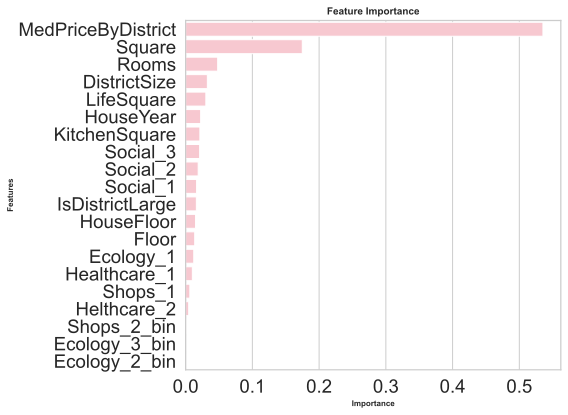

None

In [133]:
feats = {}
for feature, importance in zip(X_train.columns, model.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(6,6)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='pink')
plt.xlabel('Importance', fontsize=8, weight = 'bold')
plt.ylabel('Features', fontsize=8, weight = 'bold')
plt.title('Feature Importance', fontsize=10, weight = 'bold')
display(plt.show())

### Наиболее важные признаки это сгенерированная нами новая переменная с медианной ценой , площадь и кол-во комнат

In [134]:
# помним что у нас есть test

In [135]:
# убедимся, что данные загрузились и были параллельно предобработаны
test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,725,58,2,49.882643,33.432782,6.0,6,14,1972,0.310199,...,900.0,0,0,B,1,1,1,85,0,166809.665642
1,15856,74,2,69.263183,32.361725,3.0,1,1,1977,0.075779,...,900.0,0,2,B,1,1,1,54,0,242515.793425
2,15664,47,2,73.046609,51.940842,9.0,22,22,2007,0.101872,...,900.0,3,3,B,1,1,1,49,0,222227.584211
3,14275,27,1,47.527111,43.387569,3.0,17,17,2017,0.072158,...,900.0,0,0,A,1,1,0,358,1,117711.346469
4,7633,53,1,40.675627,32.361725,3.0,21,21,1977,0.049637,...,229.0,1,3,B,1,1,1,88,0,195474.299127


In [136]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4754 entries, 0 to 4753
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  4754 non-null   object 
 1   DistrictId          4754 non-null   object 
 2   Rooms               4754 non-null   int64  
 3   Square              4754 non-null   float64
 4   LifeSquare          4754 non-null   float64
 5   KitchenSquare       4754 non-null   float64
 6   Floor               4754 non-null   int64  
 7   HouseFloor          4754 non-null   int64  
 8   HouseYear           4754 non-null   int64  
 9   Ecology_1           4754 non-null   float64
 10  Ecology_2           4754 non-null   object 
 11  Ecology_3           4754 non-null   object 
 12  Social_1            4754 non-null   int64  
 13  Social_2            4754 non-null   int64  
 14  Social_3            4754 non-null   int64  
 15  Healthcare_1        4754 non-null   float64
 16  Helthc

In [137]:
test.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'Shops_2_bin',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict']

In [138]:
# признаки
feature_names_test = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1',  'Shops_2_bin', 'DistrictSize', 'IsDistrictLarge', 'MedPriceByDistrict']

In [139]:
print(test.isna().sum().sum())

63


In [140]:
test = test.fillna(test.mean())

In [141]:
print(test.isna().sum().sum())

0


In [142]:
X_test= test[feature_names_test]

In [143]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4754 entries, 0 to 4753
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Rooms               4754 non-null   int64  
 1   Square              4754 non-null   float64
 2   LifeSquare          4754 non-null   float64
 3   KitchenSquare       4754 non-null   float64
 4   Floor               4754 non-null   int64  
 5   HouseFloor          4754 non-null   int64  
 6   HouseYear           4754 non-null   int64  
 7   Ecology_1           4754 non-null   float64
 8   Ecology_2_bin       4754 non-null   int64  
 9   Ecology_3_bin       4754 non-null   int64  
 10  Social_1            4754 non-null   int64  
 11  Social_2            4754 non-null   int64  
 12  Social_3            4754 non-null   int64  
 13  Healthcare_1        4754 non-null   float64
 14  Helthcare_2         4754 non-null   int64  
 15  Shops_1             4754 non-null   int64  
 16  Shops_

In [144]:
scaler = StandardScaler()

X_test_scaled = scaler.fit_transform(X_test)


In [145]:
# предскажем цены квартир для новых наблюдений

y_pred_test = model.predict(X_test_scaled)

In [146]:
# запишем id объекта и предсказанную цену в датафрейм

predictions = pd.DataFrame({
    'Id': X_test.index,
    'Price': y_pred_test
})

In [147]:
predictions.head()

,Id,Price
0,0,99379.896055
1,1,373693.269128
2,2,232824.903734
3,3,82315.620774
4,4,130770.379905


In [148]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4754 entries, 0 to 4753
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      4754 non-null   int64  
 1   Price   4754 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 74.4 KB


In [149]:
# на входе у нас было 4754 значения, спрогнозировали все 4754 значения

In [150]:
# сохраним предсказания в csv файл

predictions.to_csv('SZolotukhina_predictions.csv', sep=',', index=False, encoding='utf-8')

# время работы программы\модели 5 минут